In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sb

In [16]:
df_master = pd.read_csv('../Data/master_data.csv')
#drop the index column
df_master = df_master.drop(columns=['index'])

#create a dataframe for each bus line
#will drop the date column for now, will add as day of week later
df_67 = df_master[df_master['line'] == 67].drop(columns=['line', 'date'])
df_80 = df_master[df_master['line'] == 80].drop(columns=['line', 'date'])
df_100 = df_master[df_master['line'] == 100].drop(columns=['line', 'date'])
df_121 = df_master[df_master['line'] == 121].drop(columns=['line', 'date'])
df_139 = df_master[df_master['line'] == 139].drop(columns=['line', 'date'])
df_439 = df_master[df_master['line'] == 439].drop(columns=['line', 'date'])
df_467 = df_master[df_master['line'] == 467].drop(columns=['line', 'date'])
df_480 = df_master[df_master['line'] == 480].drop(columns=['line', 'date'])



In [17]:
df_67.head()

,delay_start,start_time,temp_start,rain_amt,snow_amt,delay_end
0,0.0,17,15.1,0.0,0.0,3.0
1,0.0,41,15.1,0.0,0.0,10.0
2,-1.0,70,13.7,0.0,0.0,-6.0
3,-1.0,309,11.8,0.0,0.0,12.0
4,0.0,337,11.8,0.0,0.0,7.0


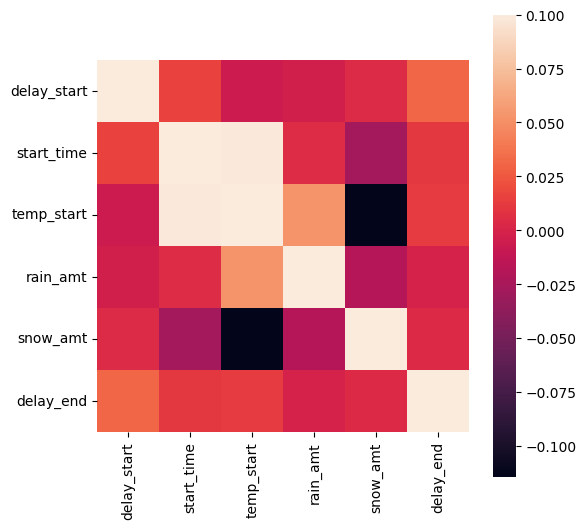

In [23]:
Corr_mat = df_67.corr()
fig = plt.figure(figsize = (6,6))

sb.heatmap(Corr_mat, vmax = .1, square = True)
plt.show()